In [1]:
] activate .

  Activating project at `~/.julia/dev/HJB/examples`


In [15]:
] st

Status `~/.julia/dev/HJB/examples/Project.toml`
  [0c46a032] DifferentialEquations v7.11.0
  [a3cb4e6c] HJB v1.0.0-DEV `~/.julia/dev/HJB`
  [91a5bcdd] Plots v1.39.0
  [5d786b92] TerminalLoggers v0.1.7


In [16]:
] gc

      Active manifest files: 8 found
      Active artifact files: 89 found
      Active scratchspaces: 2 found
     Deleted no artifacts, repos, packages or scratchspaces


In [17]:
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

Logging.ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Logging.default_metafmt, true, 0, Dict{Any, Int64}())

In [50]:
using BenchmarkTools, StaticArrays, Plots, DifferentialEquations, OffsetArrays

In [51]:
Threads.nthreads()

16

In [52]:
module HJB

using StaticArrays
using OffsetArrays
import Base.step
using DifferentialEquations
import Base.Threads.@threads

struct Grid{D, F}
    x0::NTuple{D, F}
    dx::NTuple{D, F}
    Ns::NTuple{D, Int}
    padding::Int
end

function Grid(xs::T) where {D, R<:AbstractRange, T<:NTuple{D, R}}
    x0 = ntuple(i-> xs[i][1], D)
    dx = ntuple(i-> step(xs[i]), D)
    Ns = ntuple(i-> length(xs[i]), D)
    padding = 3

    return Grid(x0, dx, Ns, padding)
end


function ind2state(grid::Grid{D, F}, ind::CartesianIndex) where {D, F}
    return SVector{D, F}(ntuple(i-> grid.x0[i] + (ind[i]) * grid.dx[i], D))
end

function state2ind(grid::Grid{D, F}, state) where {D, F}
    ind = ntuple(i-> round(Int, (state[i] - grid.x0[i]) ÷ grid.dx[i]) , D)
    return CartesianIndex(ind...)
end

# gets the indicies of the cells in the domain (i.e., without the ghost cells)
function DomainIndices(grid::Grid{D, F}) where {D, F}
    return CartesianIndices(ntuple(i-> (0:(grid.Ns[i]-1)), D))
end

function get_domain_axes(grid::Grid{D, F}, dim) where {D, F}
    return grid.x0[dim] .+ (0:(grid.Ns[dim]-1)) * grid.dx[dim]
end

function LeftBoundaryIndices(grid::Grid{D, F}, ax) where {D, F}    
    return CartesianIndices(ntuple(i -> (i == ax) ? (0:0) : (0:(grid.Ns[i]-1)), D))
end
function RightBoundaryIndices(grid::Grid{D, F}, ax) where {D, F}
    Nax = grid.Ns[ax]-1
    return CartesianIndices(ntuple(i -> (i == ax) ? (Nax:Nax) : (0:(grid.Ns[i]-1)), D))
end

function allocate_grid(grid::Grid{D, F}, f) where {D, F}
    new_size = grid.Ns .+ (2 * grid.padding)
    data = zeros(new_size)

    # create offset arrays
    new_axes = ntuple( i -> ( (-grid.padding):(grid.Ns[i] + grid.padding-1)), D)
    odata = OffsetArray(data, new_axes...)

    # now fill with the function
    @threads for ind in DomainIndices(grid)
        x = ind2state(grid, ind)
        odata[ind] = f(x)
    end
    
    return odata
end

@inline function step(ind::CartesianIndex, dim::Integer, n::Integer)
    return Base.setindex(ind, ind[dim] + n, dim)
end

abstract type GradientMethod end

struct SimpleLeft <: GradientMethod end # for ind0, returns (ind0 - ind-) / dx
struct SimpleRight <: GradientMethod end # for ind0, returns (ind+ - ind0) / dx
struct Central <: GradientMethod end # for ind0 returns (ind+ - ind-) / (2dx)
struct WenoLeft <: GradientMethod end
struct WenoRight <: GradientMethod end


function gradient(method::SimpleLeft, data, grid, ind, dim)
    indH = ind
    indL = step(ind, dim, -1)
    return (data[indH] - data[indL]) / grid.dx[dim]
end

function gradient(method::SimpleRight, data, grid, ind, dim)
    indH = step(ind, dim, 1)
    indL = ind
    return (data[indH] - data[indL]) / grid.dx[dim]
end

function gradient(method::Central, data, grid, ind, dim)
    indH = step(ind, dim, 1)
    indL = step(ind, dim, -1)
    return (data[indH] - data[indL]) / (2*grid.dx[dim])
end

function gradient(method::WenoLeft, data, grid, ind, dim)

    # refer to Section 3.4 of Osher Fedkiw Level Set Methods
    v = ntuple( i-> gradient(SimpleLeft(), data, grid, step(ind, dim, i-3), dim), 5)
    return weno(v)
    
end

function gradient(method::WenoRight, data, grid, ind, dim)

    # refer to Section 3.4 of Osher Fedkiw Level Set Methods

    # v = zeros(5)
    # for i = 1:5
    #     ii = step(ind, dim, 3-i)
    #     # @show ii
    #     v[i] = gradient(SimpleRight(), data, grid, ii, dim)
    # end
    # return weno(v)

    v = ntuple( i-> gradient(SimpleRight(), data, grid, step(ind, dim, 3 - i), dim), 5)
    return weno(v)
end

function weno(v)
    v1, v2, v3, v4, v5 = v

    # see chapter 3.5 of Osher, Fedkiw Level Set Methods and Dynamic Implicit Surfaces

    # compute the eno derivatives
    ϕ_x_1 = (1/3) * v1 + (-7/6) * v2 + (11/6) * v3 
    ϕ_x_2 = (-1/6) * v2 + (5/6) * v3 + (1/3) * v4 
    ϕ_x_3 = (1/3) * v3 + (5/6) * v4 + (-1/6) * v5

    # compute smoothness of the stencils
    S1 = (13 / 12) * (v1 - 2 * v2 + v3)^2 + (1 / 4) * (v1 - 4 * v2 + 3 * v3)^2
    S2 = (13 / 12) * (v2 - 2 * v3 + v4)^2 + (1 / 4) * (v2 - v4)^2
    S3 = (13 / 12) * (v3 - 2 * v4 + v5)^2 + (1 / 4) * (3 * v3 - 4 * v4 + v5)^2

    # get the weights
    # ϵ0=1e-6
    # ϵ1=1e-12
    # ϵ = ϵ0 * max(v1^2, v2^2, v3^2, v4^4, v5^2) + ϵ1
    ϵ = 1e-6
    α1 = (1 / 10) / (S1 + ϵ)^2
    α2 = (3 / 5) / (S2 + ϵ)^2
    α3 = (3 / 10) / (S3 + ϵ)^2
    α = α1 + α2 + α3

    w1 = α1 / α
    w2 = α2 / α
    w3 = α3 / α

    return w1 * ϕ_x_1 + w2 * ϕ_x_2 + w3 * ϕ_x_3
end



function update_ghost_nodes!(data, grid::Grid{D, F}) where {D, F}

    for dim=1:D
        update_ghost_nodes_left!(data, grid, dim)
        update_ghost_nodes_right!(data, grid, dim)
    end
    
end

function update_ghost_nodes_left!(data, grid::Grid{D, F}, dim) where {D, F}

    pad = grid.padding
    
    # consider any index
    @inbounds @threads for ind in LeftBoundaryIndices(grid, dim)
        # estimate the gradient
        grad = gradient(SimpleRight(), data, grid, ind, dim)
        # fill values
        for i=1:pad
            ghost_ind = step(ind, dim, -i)
            data[ghost_ind] = data[ind] + grad * (-i * grid.dx[dim])
        end
    end 
end

function update_ghost_nodes_right!(data, grid::Grid{D, F}, dim) where {D, F}

    pad = grid.padding
    
    # consider any index
    @inbounds @threads for ind in RightBoundaryIndices(grid, dim)
        # estimate the gradient
        grad = gradient(SimpleLeft(), data, grid, ind, dim)
        # fill values in the ghost cells
        for i=1:pad
            ghost_ind = step(ind, dim, i)
            data[ghost_ind] = data[ind] + grad * (i * grid.dx[dim])
        end
    end
end


function update_domain_nodes!(Ddata, data::AT, grid::Grid{D, F}, hamiltonian, t) where {D, F, T, AT<:AbstractArray{T, D}}

    @inbounds @threads for ind in DomainIndices(grid)

        # get the DxV gradients
        DxV_left = SVector{D, T}(ntuple(dim -> gradient(WenoLeft(), data, grid, ind, dim), D))
        DxV_right = SVector{D, T}(ntuple(dim -> gradient(WenoRight(), data, grid, ind, dim), D))

        DxV = (DxV_left .+ DxV_right) ./ 2
        dDxV = (DxV_left .- DxV_right) ./ 2
        α = (1.0e-0, 1.0e-0)

        # get the x value
        x = ind2state(grid, ind)

        # get the V value
        V = data[ind]

        # store the dV/dt
        Ddata[ind] = - (hamiltonian(t, x, V, DxV) - sum(α .* dDxV))
    end
    
end

function get_ODE_RHS!(hamiltonian, grid)
   
    function ODE_RHS!(DV, V, params, time)

        # set all the DV to 0 first
        # DV .= 0 # not sure if i need to do this
    
        # first update the ghost nodes
        update_ghost_nodes!(V, grid)

        # next update all the interior cells
        update_domain_nodes!(DV, V, grid, hamiltonian, time)

        return
    
    end

    return ODE_RHS!
end

function get_ODEProblem(hamiltonian, l, grid, tspan)

    # create the initial grid
    V0 = allocate_grid(grid, l)

    # get the RHS
    RHS! = get_ODE_RHS!(hamiltonian, grid)

    # construct the ODE Problem
    prob = ODEProblem(RHS!, V0, tspan)

    return prob

end

end

Main.HJB

In [53]:
function plot_grid!(data, grid::HJB.Grid{2, F}) where {F}
    # for now only supports plotting 2 dimensional problems

    x1s = HJB.get_domain_axes(grid, 1)
    x2s = HJB.get_domain_axes(grid, 2)

    heatmap!(x1s, x2s, data[HJB.DomainIndices(grid)]')

end

plot_grid! (generic function with 1 method)

In [54]:
# define the dynamics
function f(t, x, u)
    return @SVector [x[2], u[1]]
end

# define the Hamiltonian
function H(t, x, V, DxV)
    u1 = @SVector [1.0]
    u2 = @SVector [-1.0]
    H1 = DxV' * f(t, x, u1)
    H2 = DxV' * f(t, x, u2)
    γ = 0.5
    
    return min(0, max(H1, H2) + γ*V)
end

# define the constraint function
function l(x)
    # xcon = 1.8 - x[1] 
    xcon = 0.5 - x[1]^2
    # vcon = 1.5 - x[2]
    # return min(xcon, vcon)
    return xcon
end

l (generic function with 1 method)

In [55]:
x1s = -1:0.025:1
x2s = -2:0.025:2
grid = HJB.Grid((x1s, x2s))

Main.HJB.Grid{2, Float64}((-1.0, -2.0), (0.025, 0.025), (81, 161), 3)

In [56]:
_RHS! = HJB.get_ODE_RHS!(H, grid)

(::Main.HJB.var"#ODE_RHS!#39"{typeof(H), Main.HJB.Grid{2, Float64}}) (generic function with 1 method)

In [57]:
_prob = HJB.get_ODEProblem(H, l, grid, (0.0, -2.0))

ODEProblem with uType OffsetMatrix{Float64, Matrix{Float64}} and tType Float64. In-place: true
timespan: (0.0, -2.0)
u0: 87×167 OffsetArray(::Matrix{Float64}, -3:83, -3:163) with eltype Float64 with indices -3:83×-3:163:
 0.0  0.0  0.0   0.0        0.0       …   0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0        0.0       0.0  0.0  0.0
 0.0  0.0  0.0  -0.5       -0.5          -0.5       -0.5       0.0  0.0  0.0
 0.0  0.0  0.0  -0.450625  -0.450625     -0.450625  -0.450625  0.0  0.0  0.0
 0.0  0.0  0.0  -0.4025    -0.4025    …  -0.4025    -0.4025    0.0  0.0  0.0
 0.0  0.0  0.0  -0.355625  -0.355625     -0.355625  -0.355625  0.0  0.0  0.0
 0.0  0.0  0.0  -0.31      -0.31         -0.31      -0.31      0.0  0.0  0.0
 0.0  0.0  0.0  -0.265625  -0.265625     -0.265625  -0.265625  0.0  0.0  0.0
 0.0  0.0  0.0  -0.2225    -0.2225       -0.2225    -0.2225    0.0  0.0  0.0
 0.0  0.0

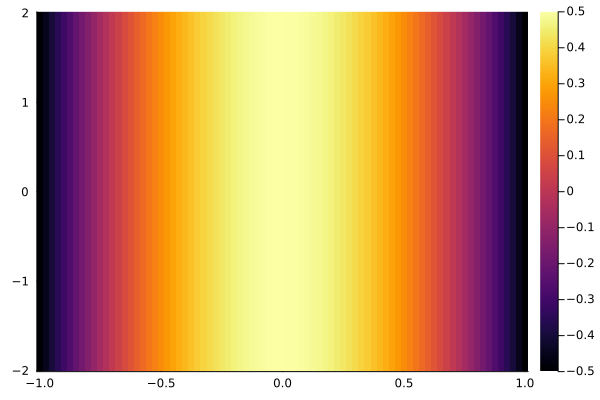

In [58]:
plot()
plot_grid!(_prob.u0, grid)

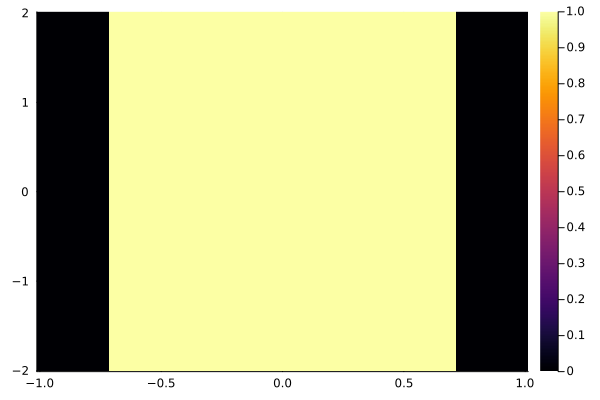

In [59]:
plot()
plot_grid!(_prob.u0 .>= 0.0, grid)

In [60]:
du0 = similar(_prob.u0)
du0 .= 0.0;

In [61]:
_RHS!(du0, _prob.u0, nothing, 0.0)
@time _RHS!(du0, _prob.u0, nothing, 0.0)

  0.001477 seconds (406 allocations: 44.891 KiB)


In [62]:
@btime _RHS!($du0, $_prob.u0, nothing, 0.0)

  550.189 μs (407 allocations: 44.92 KiB)


In [63]:
?SSPRK53

search: SSPRK53 SSPRK53_H SSPRK53_2N2 SSPRK53_2N1 SSPRK54 SSPRK83 SSPRK73



```julia
SSPRK53(; stage_limiter! = OrdinaryDiffEq.trivial_limiter!,
        step_limiter! = OrdinaryDiffEq.trivial_limiter!,
        thread = OrdinaryDiffEq.False(),)
```

Explicit Runge-Kutta Method. A third-order, five-stage explicit strong stability preserving (SSP) method. Fixed timestep only.

### Keyword Arguments

  * `stage_limiter!`: function of the form `limiter!(u, integrator, p, t)`
  * `step_limiter!`: function of the form `limiter!(u, integrator, p, t)`
  * `thread`: determines whether internal broadcasting on  appropriate CPU arrays should be serial (`thread = OrdinaryDiffEq.False()`,  default) or use multiple threads (`thread = OrdinaryDiffEq.True()`) when  Julia is started with multiple threads.

## References

Ruuth, Steven.     Global optimization of explicit strong-stability-preserving Runge-Kutta methods.     Mathematics of Computation 75.253 (2006): 183-207


In [64]:
cb = TerminateSteadyState(1e-3, 1e-2)

DiscreteCallback{DiffEqCallbacks.var"#73#75"{Nothing, Float64, Float64, typeof(DiffEqCallbacks.allDerivPass)}, DiffEqCallbacks.var"#74#76", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(DiffEqCallbacks.var"#73#75"{Nothing, Float64, Float64, typeof(DiffEqCallbacks.allDerivPass)}(nothing, 0.001, 0.01, DiffEqCallbacks.allDerivPass), DiffEqCallbacks.var"#74#76"(), SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 0])

In [65]:
 # SSPRK54() # good
# SSPRK53() # good
# SSPRK22() # good
# SSPRK43() # very slow
# Tsit5() # good
# unspecified # good

@time _sol = solve(_prob; reltol=1e-6, abstol=1e-6, progress=true,  dt=1e-3, alg=SSPRK53(), callback=cb)

ODE   0%|                                               |  ETA: N/A
ODE  50%|███████████████████████▌                       |  ETA: 0:00:07
ODE 100%|███████████████████████████████████████████████|  ETA: N/A


 15.334696 seconds (10.29 M allocations: 1.273 GiB, 3.39% gc time)


ODE 100%|███████████████████████████████████████████████| Time: 0:00:11


retcode: Success
Interpolation: 3rd order Hermite
t: 2002-element Vector{Float64}:
  0.0
 -0.001
 -0.002
 -0.003
 -0.004
 -0.005
 -0.006
 -0.007
 -0.008
 -0.009000000000000001
 -0.010000000000000002
 -0.011000000000000003
 -0.012000000000000004
  ⋮
 -1.9899999999998916
 -1.9909999999998915
 -1.9919999999998914
 -1.9929999999998913
 -1.9939999999998912
 -1.994999999999891
 -1.995999999999891
 -1.9969999999998909
 -1.9979999999998908
 -1.9989999999998906
 -1.9999999999998905
 -2.0
u: 2002-element Vector{OffsetMatrix{Float64, Matrix{Float64}}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … 

In [66]:
_sol.alg

SSPRK53(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)

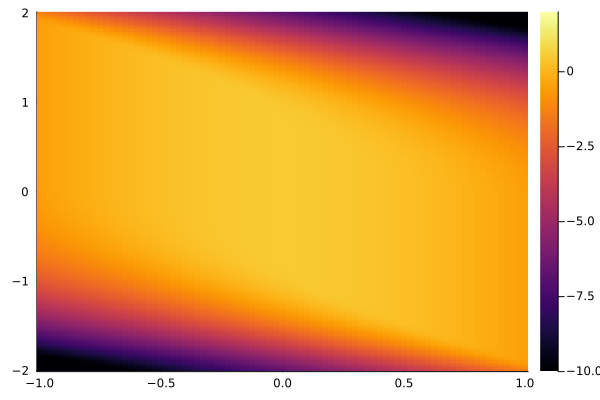

In [67]:
plot()
plot_grid!(_sol.u[end], grid)
plot!(clims=(-10, 2))

In [68]:
_sol.t

2002-element Vector{Float64}:
  0.0
 -0.001
 -0.002
 -0.003
 -0.004
 -0.005
 -0.006
 -0.007
 -0.008
 -0.009000000000000001
 -0.010000000000000002
 -0.011000000000000003
 -0.012000000000000004
  ⋮
 -1.9899999999998916
 -1.9909999999998915
 -1.9919999999998914
 -1.9929999999998913
 -1.9939999999998912
 -1.994999999999891
 -1.995999999999891
 -1.9969999999998909
 -1.9979999999998908
 -1.9989999999998906
 -1.9999999999998905
 -2.0

In [69]:
_sol.u[end] |> length

14529

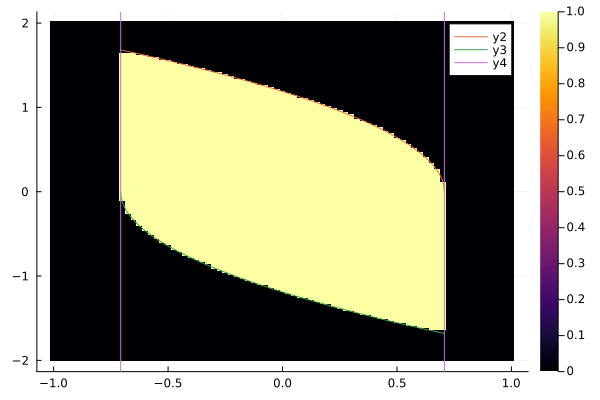

In [70]:
plot()
plot_grid!(_sol.u[end] .>= 0.0, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

In [71]:
VF = _sol.u[end];

In [72]:
LfVF = similar(VF)
for ind in HJB.DomainIndices(grid)
    x = HJB.ind2state(grid, ind)
    fx = @SVector [x[2], 0]
    DxV = @SVector [HJB.gradient(HJB.Central(), VF, grid, ind, dim) for dim=1:2]
    LfVF[ind] = DxV' * fx
end

# sup_u (LgV * u)
LgVFu_max = similar(VF)
for ind in HJB.DomainIndices(grid)
    x = HJB.ind2state(grid, ind)
    gx = @SVector [ 0, 1]
    DxV = @SVector [HJB.gradient(HJB.Central(), VF, grid, ind, dim) for dim=1:2]
    LgVFu_max[ind] = max(DxV' * gx * -1, DxV' * gx * 1)
end

dVdt = similar(VF)
dVdt .= 0
_RHS!(dVdt, VF, nothing, 0.0)

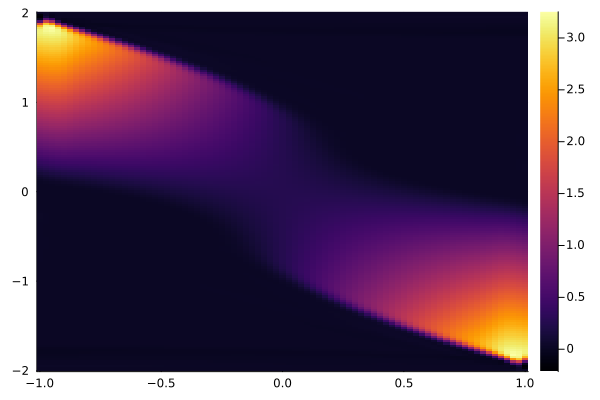

In [73]:
plot()
plot_grid!(dVdt + LfVF + LgVFu_max + 0.5 * VF, grid)

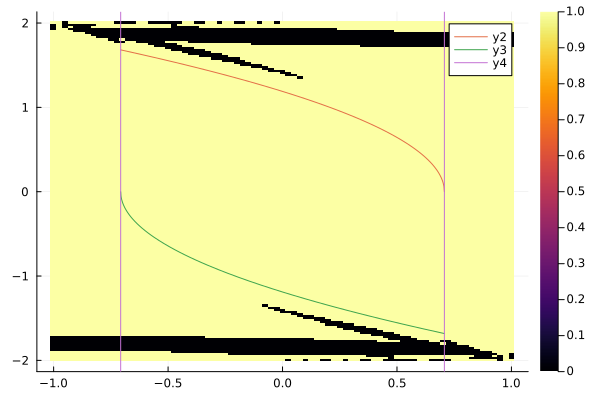

In [74]:
plot()
plot_grid!(dVdt + LfVF + LgVFu_max + 0.5 * VF .>= -1e-6, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])
# plot!(p-> sqrt(2 * 1 * (1.8 - p)), 0.0, 1.8)
# # hline!([1.5])

In [75]:
safe_inds = VF[HJB.DomainIndices(grid)] .>= 0
unsafe_inds = VF[HJB.DomainIndices(grid)] .< 0

81×161 BitMatrix:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  

In [76]:
cbf_condition = dVdt + LfVF + LgVFu_max + 0.5 * VF
sub_cbf_condition = cbf_condition[HJB.DomainIndices(grid)]

81×161 Matrix{Float64}:
  4.80391e-10   0.00214243    0.013581     …  -0.162793     -1.15508e-9
  8.57429e-10   0.00213229    0.0133912        0.0325642     0.0417378
 -1.51863e-10   0.00212224    0.0132012       -0.0401967    -0.00550986
  6.97256e-10   0.00211229    0.0130109       -0.00375898    0.00521447
  4.39296e-9    0.00210247    0.0128205       -0.0064285     0.000130683
  6.40581e-9    0.00209277    0.0126297    …  -0.00272557    0.000579759
  3.21656e-9    0.0020832     0.0124388       -0.00137024    0.000118643
 -1.67885e-9    0.00207378    0.0122475       -7.28882e-5    0.000102728
 -3.91787e-9    0.00206453    0.0120561        0.000523245   3.9615e-5
 -3.64375e-9    0.00205545    0.0118643        0.000829932   2.01136e-5
 -2.86817e-9    0.00204655    0.0116722    …   0.000975513   1.34726e-6
 -3.17647e-9    0.00203784    0.0114798        0.00103903   -4.30412e-6
 -3.11526e-9    0.00202934    0.011287         0.00103977   -6.62947e-6
  ⋮                                   

In [77]:
minimum(sub_cbf_condition[safe_inds])

0.000284517216236698

In [78]:
0.00028451711749507246

0.00028451711749507246

In [79]:
minimum(sub_cbf_condition[unsafe_inds])

-0.21578386619584522

In [81]:
using LinearAlgebra

In [82]:
dot([-1, 1], [1, 1])

0

In [83]:
dot((-1, 1), [1, 1])

0